In [93]:
# basic packages
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")


#Shared/Utility scripts
import sys
sys.path.insert(0, '../..') #sys allows for the .ipynb file to connect to the shared folder files
from shared_scripts import Simple_Eval, dataloader, xgb_model, xgb_dataprocessing


HOME = os.path.expanduser('~')
modelname = 'XGBoost'
model_path = f"{HOME}/NWM_ML/Model/{modelname}"

print(f"{modelname} development script")

XGBoost development script


## 2. Prepare the data.

In [12]:
modelname = 'XGBoost'
model_path = f"{HOME}/NWM_ML/Model/{modelname}"

cfsday_AFday = 1.983

#input columns
input_columns =[
                'Lat', 
                #'Long', 
                #'Drainage_area_mi2', 
                'Mean_Basin_Elev_ft',       
                #'Perc_Forest', 
                'Perc_Develop', 
                #'Perc_Imperv', 
                #'Perc_Herbace',       
                'Perc_Slop_30', 
                #'Mean_Ann_Precip_in', 
                's1',       
                's2', 
                'storage', 
                'swe', 
                'NWM_flow', 
                'DOY', 
                'tempe(F)', 
                #'precip(mm)'
                ]

target = 'flow_cfs'

test_years = [2019, 2020]                 

#load data
datapath = f"{HOME}/NWM_ML/Data/input"
trainingfile = "final_input.parquet"

df, StreamStats = dataloader.get_ML_Data(datapath, trainingfile)
df.head()

df needs no processing


,station_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,...,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY,tempe(F),precip(mm)
0,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-28,78.55521,-0.891007,-0.453991,0.0,1.2,55.0,301,39.239582,0.0
1,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-29,98.61146,-0.891007,-0.453991,0.0,1.2,55.0,302,45.068712,0.0
2,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-30,97.60208,-0.891007,-0.453991,0.0,1.1,54.0,303,50.945891,0.0
3,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-31,99.33125,-0.891007,-0.453991,0.0,1.2,54.0,304,45.480097,0.0
4,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-11-01,95.76354,-0.998630,0.052336,0.0,1.2,54.0,305,46.656777,0.0


### Dataprocessing
* Editing the features based on the feature importance
* Remove headwater stations from dataset
* make sure dates are in datetime format

In [89]:
#get non headwater stations
headwater_stations = ['10011500', # Bear River headwaters before WY state line
                      '10109000', # Logan River above dams
                      '10113500', # HW Blacksmith fork
                      '10128500', # Upper Weber above Oakley
                      '10131000', #Chalk creek before Weber - lots of upstream irrigation, potentially include
                        '10146400', #Currant Creek above Mona Reservoir - lots of upstream irrigation, potentially include
                        '10150500', #Spanish fork after diamond fork - potentially include because of 6th water diversion CUP
                        '10154200', #Upper Provo river after confluence of N/S forks - potentially include because of duchense tunnel water diversion CUP
                        '10172700', #Vernon creek 2 ranges west of Utah Lake, shouldnt be included because not in GSL basin 
                        '10172800', #Willow creek west of Gransville,  shouldnt be included because does not make it to GSL
                          '10172952'
                          ] #Dunn creek in Raft River Range, shouldnt be included because drains to bonnevile salt flats 

#remove headwater stations
df = df[~df['station_id'].isin(headwater_stations)]

#get stations with correct swe and storage features
#The following sites have swe 

'''
['10011500', '10105900', '10109000', '10126000', '10131000',
       '10133650', '10133800', '10133980', '10134500', '10136500',
       '10140700', '10141000', '10150500', '10154200', '10155000',
       '10155200']
'''

#the following sites have swe and storage
'''
['10126000', '10134500', '10136500', '10140700', '10141000',
       '10155200']
'''

stations = df['station_id'][(df['swe']>0) & (df['storage']>0)].unique()

#Train model with these stations
df = df[df['station_id'].isin(stations)]

#convert dates to datetime format
df.datetime = pd.to_datetime(df.datetime)

# #reset index to clean up df
df.reset_index( inplace =  True, drop = True)

#fit a scaler,save, and scale the training data
x_train, y_train, x_test, y_test, station_index_list = xgb_dataprocessing.xgb_train_test(
                                                      df,
                                                      test_years, 
                                                      target, 
                                                      input_columns
                                                      )



## 3. XGBOOST Model Preparation.

### 3.3. Run and evaluate the model
Here first we train the model and then we test it.
We do it 30 times so we have firm evaluation. 

In [116]:
import importlib
importlib.reload(xgb_model)

<module 'shared_scripts.xgb_model' from '/home/rjohnson18/NWM_ML/RJ/ModelDevelopment/../../shared_scripts/xgb_model.py'>

Trial Number 0 ==========================================================
Tuning hyperparametetrs on 25.0% of training data
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END eta=0.1, max_depth=2, n_estimators=100;, score=-108.536 total time=   0.6s
[CV 2/3] END eta=0.1, max_depth=2, n_estimators=100;, score=-106.127 total time=   0.6s
[CV 3/3] END eta=0.1, max_depth=2, n_estimators=100;, score=-104.032 total time=   0.7s
Best parameters found: {'eta': 0.1, 'max_depth': 2, 'n_estimators': 100}
Best RMSE: -106.23164430149195
Mean MAE: 106.694 (6.213)
Training model with optimized hyperparameters


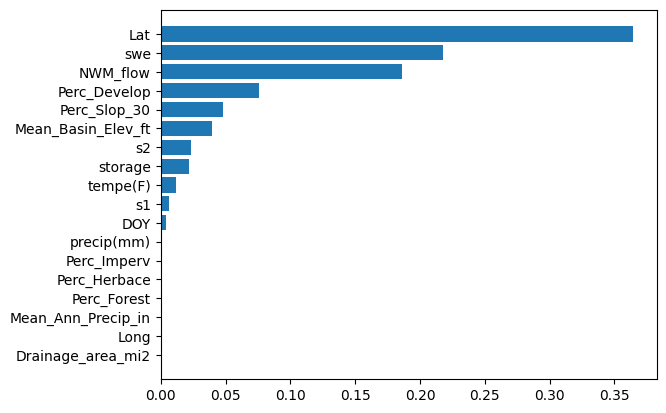

Saving Model
Run is Done!Run Time: 7.57570743560791 seconds 


In [117]:
#Train model
tries = 1 #what is tries?
hyperparameters = {
    'max_depth': range (2, 5, 5),
    'n_estimators': range(100, 1000, 1000),
    'eta': [0.1,]
}
perc_data = 0.25 # percent of training data used to identify optimial hyperparameters
xgb_model.XGB_Train(model_path, 
                    input_columns, 
                    station_index_list, 
                    x_train, 
                    y_train, 
                    tries, 
                    hyperparameters,
                    perc_data)

In [113]:
imp = [0.36442962,
        0.,
        0.,
        0.03974767,
        0.,         
        0.07574472,
        0.,     
        0.,         
        0.04827607, 
        0.,         
        0.00664634, 
        0.02306727,
        0.02217619, 
        0.21807906,
        0.18636385,
        0.00405619,
        0.01141306, 
        0.        ]

feats = ['Lat', 'Long', 'Drainage_area_mi2', 'Mean_Basin_Elev_ft', 'Perc_Forest', 'Perc_Develop', 'Perc_Imperv', 'Perc_Herbace', 'Perc_Slop_30', 'Mean_Ann_Precip_in', 's1', 's2', 'storage', 'swe', 'NWM_flow', 'DOY', 'tempe(F)', 'precip(mm)']

list1, list2 = zip(*sorted(zip(imp, feats), reverse=True))
list2


('Lat',
 'swe',
 'NWM_flow',
 'Perc_Develop',
 'Perc_Slop_30',
 'Mean_Basin_Elev_ft',
 's2',
 'storage',
 'tempe(F)',
 's1',
 'DOY',
 'precip(mm)',
 'Perc_Imperv',
 'Perc_Herbace',
 'Perc_Forest',
 'Mean_Ann_Precip_in',
 'Long',
 'Drainage_area_mi2')

In [92]:
#test model
Preds_Dict = xgb_model.XGB_Predict(model_path,
                      modelname,  
                      df,
                      x_test, 
                      y_test, 
                      test_years, 
                      StreamStats, 
                      station_index_list)


USGS site: 10126000


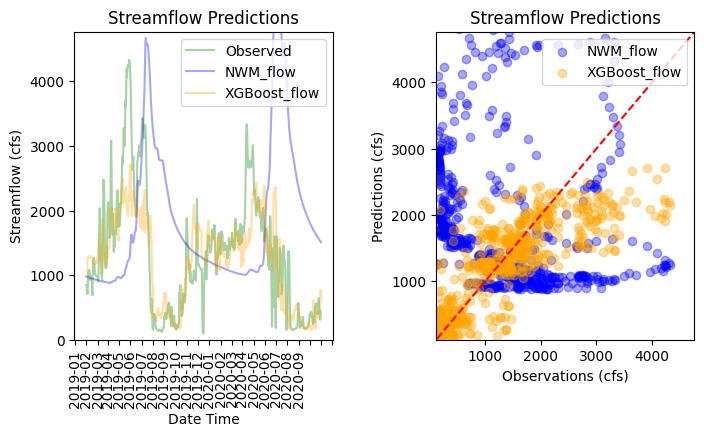

USGS site: 10134500


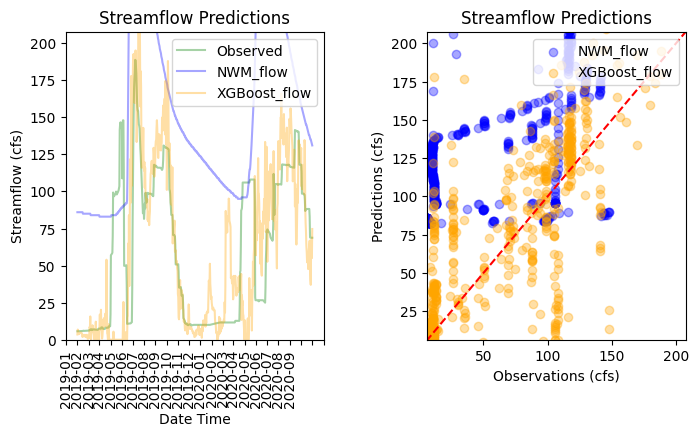

USGS site: 10136500


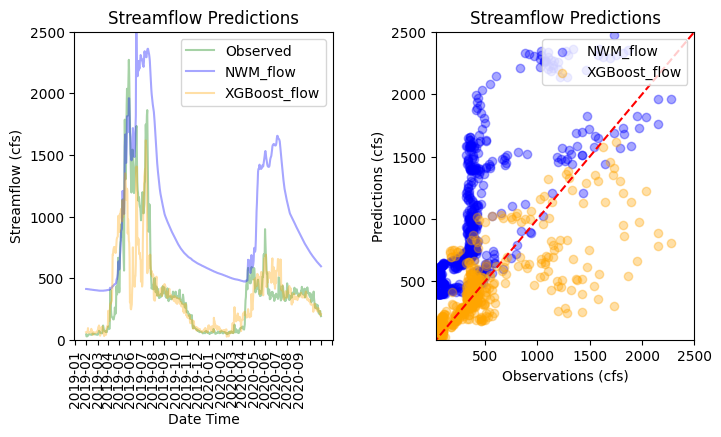

USGS site: 10140700


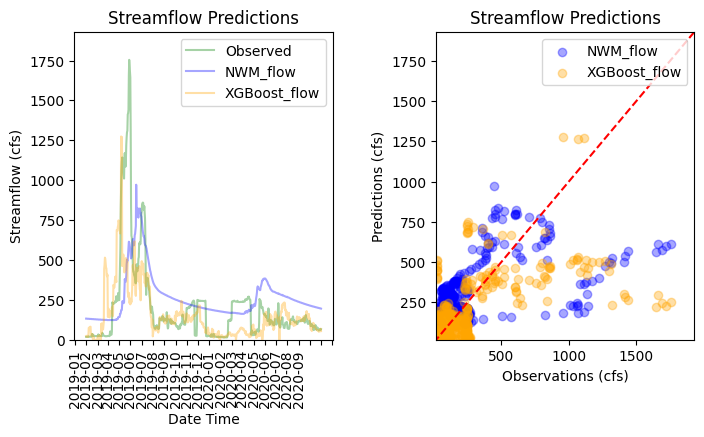

USGS site: 10141000


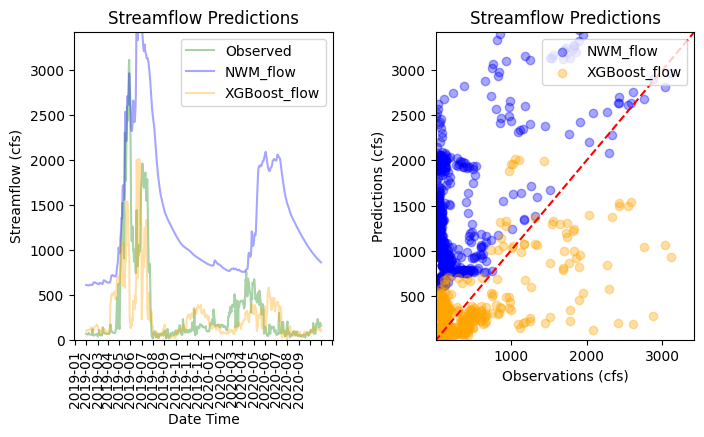

USGS site: 10155200


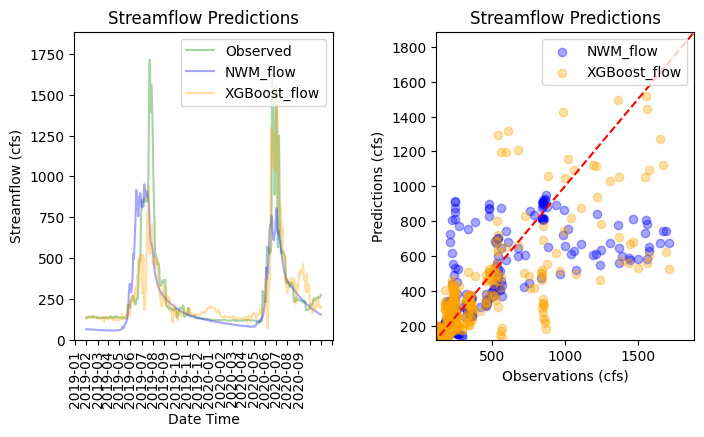

,NWM_flow_kge,XGBoost_flow_kge,NWM_flow_rmse,XGBoost_flow_rmse,NWM_flow_mape,XGBoost_flow_mape,NWM_flow_pbias,XGBoost_flow_pbias
station_id,,,,,,,,
10155200,0.63,0.67,192.0,182.0,29.28,23.50,15.23,7.89
10134500,-0.97,0.65,132.0,44.0,545.15,83.81,-173.33,1.78
10126000,-0.31,0.63,1716.0,597.0,306.30,48.65,-39.65,7.99
10136500,-0.42,0.61,644.0,269.0,330.76,39.17,-137.08,10.20
10141000,-2.10,0.47,1169.0,388.0,1111.22,97.50,-304.72,18.31
10140700,0.29,0.37,236.0,229.0,221.61,92.94,-30.30,23.67


In [94]:
#Evaluate model
#Evaluate model performance of the different models, 'flow_cfs_pred', 
prediction_columns = ['NWM_flow', f"{modelname}_flow"]
Eval_DF = Simple_Eval.Simple_Eval(Preds_Dict, 
                                prediction_columns, 
                                modelname, 
                                supply = False,
                                plots = True, 
                                keystats = False        
                                )

Eval_DF